---
title: 06 - mouse query
date: 10-07-2023
author: Martin Proks
---

In [1]:
%matplotlib inline

import scvi
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
warnings.simplefilter('ignore', category=FutureWarning)
warnings.simplefilter('ignore', category=UserWarning)

scvi.settings.seed = 0

/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
[rank: 0] Global seed set to 0


In [23]:
plt.rcParams['svg.fonttype'] = 'none'

ct_colors = {
    'Zygote': '#7985A5',
    '2C': '#B3C81E',
    '4C': '#67BB30',
    '8C': '#028A46',
    '16C': '#657cbd',
    'E3.25-ICM': '#fadc8f',
    'E3.25-TE': '#5185b9',
    'E3.5-ICM': '#f8d06a',
    'E3.5-TE': '#7ba9d8',
    'E3.5-EPI': '#c38cb0',
    'E3.5-PrE': '#d97c81',
    'E3.75-ICM': '#F6C445',
    'E4.5-TE': '#5a94ce',
    'E4.5-EPI': '#B46F9C',
    'E4.5-PrE': '#D05B61'
}

## 1. Load scANVI reference model

In [3]:
# lvae = scvi.model.SCANVI.load("../results/02_mouse_integration/scanvi/")
lvae = scvi.model.SCANVI.load("../results/02_mouse_integration/scanvi_ns_15/")

INFO     File ../results/02_mouse_integration/scanvi_ns_15/model.pt already downloaded                             


## 2. Query integration

In [4]:
import anndata
import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sns


def normalize_smartseq(adata: sc.AnnData, gene_len: pd.DataFrame) -> sc.AnnData:
    print("SMART-SEQ: Normalization")

    common_genes = adata.var_names.intersection(gene_len.index)
    print(f"SMART-SEQ: Common genes {common_genes.shape[0]}")

    lengths = gene_len.loc[common_genes, "length"].values
    normalized = adata[:, common_genes].copy()
    normalized.X = normalized.X / lengths * np.median(lengths)
    normalized.X = np.rint(normalized.X)

    return normalized


def load_experiment(filename: str, GEO: str, left_on: str = 'sample', right_on='SRX'):
    adata = sc.read(filename)
    metadata = pd.read_csv(f"../pipeline/fetchngs/{GEO}_metadata.csv")

    # sometimes we have duplicates because the ID is not unique
    adata.obs = pd.merge(adata.obs, metadata, left_on=left_on, right_on=right_on)\
                    .drop_duplicates(left_on)\
                    .set_index(left_on)

    adata.obs['ct_orig'] = adata.obs['sample_title']

    return adata


genes_length = pd.read_table("../data/external/Mus_musculus_GRCm38_102_gene_length.txt").set_index('gene')
genes_length['length'] = genes_length['mean']

### 2.1. Borensztein et al., 2017 [GSE80810]

```bash
nf-core_tower.sh \
    Borensztein_query \
    nextflow run nf-core/fetchngs \
    -r 1.10.0 \
    --input /projects/dan1/data/Brickman/projects/proks-salehin-et-al-2023/pipeline/fetchngs/GSE80810_query.txt

nf-core_tower.sh Borensztein_query nextflow run brickmanlab/scrnaseq \
    -r feature/smartseq \
    -c /projects/dan1/data/Brickman/projects/proks-salehin-et-al-2023/pipeline/smartseq.config \
    --input /scratch/Brickman/pipelines/Borensztein_query/results/samplesheet/samplesheet.csv
```

In [ ]:
borenszrtein_metadata = pd.read_table("https://ftp.ncbi.nlm.nih.gov/geo/series/GSE80nnn/GSE80810/matrix/GSE80810_series_matrix.txt.gz",
                                      skiprows=31, index_col=0).T
borenszrtein_metadata['SRX'] = borenszrtein_metadata[['!Sample_relation']].iloc[:, :2].agg(' '.join, axis=1).str.extract(r'(SRX[0-9]{6})')
borenszrtein_metadata['ct'] = borenszrtein_metadata['!Sample_characteristics_ch1'].iloc[:, 1].values
borenszrtein_metadata = borenszrtein_metadata.reset_index()

legend = {
    'developmental stage: 32-cell': '32-cell',
    'developmental stage: 64-cell': '64-cell'
}

for old_name, new_name in legend.items():
    borenszrtein_metadata.loc[borenszrtein_metadata.ct == old_name, 'ct'] = new_name
    
borenszrtein_metadata = borenszrtein_metadata[borenszrtein_metadata.ct.isin(legend.values())].copy()
borenszrtein_metadata = borenszrtein_metadata[borenszrtein_metadata['!Sample_characteristics_ch1'].iloc[:, 2].str.contains('wt/wt')].copy()

borenszrtein_metadata['!Sample_geo_accession'].to_csv("../pipeline/fetchngs/GSE80810_query.txt", index=None, header=None)
borenszrtein_metadata.set_index('SRX').to_csv("../pipeline/fetchngs/GSE80810_query_metadata.csv")

In [ ]:
borensztein = load_experiment(
    "../data/external/aligned/mouse/Borensztein_query/results/star/mtx_conversions/combined_matrix.h5ad",
    GEO="GSE80810_query", left_on='sample_alias', right_on='ID_REF'
)

borensztein.obs['batch'] = "BORENSZTEIN_1"
borensztein.obs['experiment'] = "Borensztein et al., 2017"
borensztein.obs['technology'] = "qRT-PCR"

borensztein.obs = borensztein.obs[['batch', 'experiment', 'technology', 'ct', 'ct_orig']]
borensztein.obs['_ct'] = borensztein.obs['ct']
borensztein.obs.ct = 'Unknown'

borensztein = normalize_smartseq(borensztein, genes_length)

borensztein.var = borensztein.var.gene_symbol.str.lower().reset_index().set_index('gene_symbol')
borensztein.var_names_make_unique()

borensztein.X = np.asarray(borensztein.X) 
borensztein.layers['counts'] = np.asarray(borensztein.X)

sc.pp.normalize_total(borensztein)
sc.pp.log1p(borensztein)
sc.pp.highly_variable_genes(borensztein, n_top_genes=3000)
sc.pp.pca(borensztein)

sc.pp.neighbors(borensztein)
sc.tl.leiden(borensztein)

In [ ]:
sc.pl.pca(borensztein, color=['_ct', 'leiden'], size=200)

In [ ]:
scvi.model.SCANVI.prepare_query_anndata(borensztein, lvae)
lvae_q = scvi.model.SCANVI.load_query_data(borensztein, lvae)
lvae_q.train(
    max_epochs=100,
    plan_kwargs=dict(weight_decay=0.0),
    check_val_every_n_epoch=10,
)

In [ ]:
borensztein.obsm["X_scANVI"] = lvae_q.get_latent_representation()
borensztein.obs["predictions"] = lvae_q.predict()
borensztein.obs['entropy'] = 1 - lvae_q.predict(soft=True).max(axis=1)

In [ ]:
sc.pl.pca(borensztein, color=['_ct', 'leiden', 'predictions'], size=200)

In [ ]:
sc.metrics.confusion_matrix('_ct', 'predictions', borensztein.obs).plot(kind='barh', stacked=True)
plt.gca().spines[['right', 'top']].set_visible(False)
plt.gca().legend(frameon=False, bbox_to_anchor=(1, 1))

In [ ]:
sc.metrics.confusion_matrix('leiden', 'predictions', borensztein.obs).plot(kind='barh', stacked=True)
plt.gca().spines[['right', 'top']].set_visible(False)
plt.gca().legend(frameon=False, bbox_to_anchor=(1, 1))

### 2.2. Proks et al., 2023

In [ ]:
# !wget https://zenodo.org/record/8016374/files/02_dataset.h5ad?download=1 -O ../data/external/Proks_et_al_2023/02_dataset.h5ad

In [5]:
vitro = sc.read("../data/external/Proks_et_al_2023/02_dataset.h5ad")
vitro_raw = sc.AnnData(vitro.raw.X, var=vitro.raw.var, obs=vitro.obs)
vitro_raw.var_names = vitro_raw.var_names.str.lower()
vitro_raw.layers['counts'] = vitro_raw.X
vitro_raw

AnnData object with n_obs × n_vars = 1575 × 20459
    obs: 'Well_coordinates', 'plate_ID', 'Amp_batch_ID', 'Cell_barcode', 'Pool_barcode', 'Batch', 'Condition', 'SampleName', 'Stage', 'Source', 'Day', 'Index sort', 'All.Events.FSC-A.Geo.Mean', 'All.Events.SSC-A.Geo.Mean', 'All.Events.GFP-A.Geo.Mean', 'All.Events.mCherry.561D-A.Geo.Mean', 'All.Events.DAPI-A.Geo.Mean', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ercc', 'pct_counts_ercc', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'n_counts', 'S_score', 'G2M_score', 'phase', 'louvain', 'leiden', 'umap_density_Stage', 'batch', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time', 'velocity_length', 'velocity_confidence', 'velocity_confidence_transition'
    var: 'mt', 'ercc', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variabl

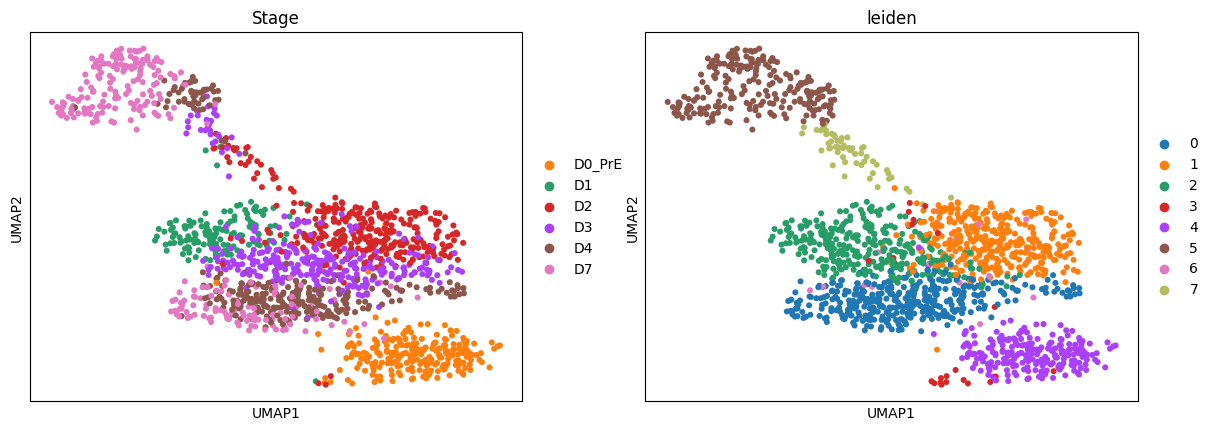

In [6]:
sc.pl.umap(vitro, color=['Stage', 'leiden'])

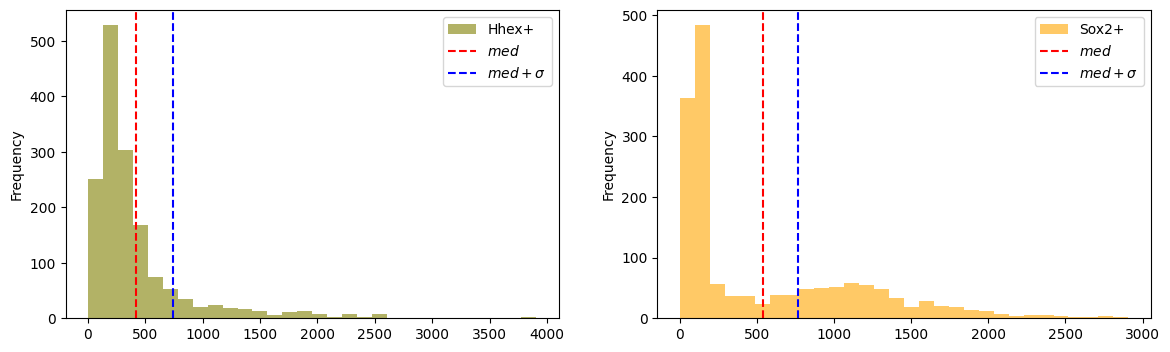

In [7]:
fig, ax = plt.subplots(1, 2, figsize=[14, 4])

hhex_protein = vitro.obs['All.Events.mCherry.561D-A.Geo.Mean']
hhex_cutoff = hhex_protein.median() + hhex_protein.std()
hhex_protein.plot(kind='hist', bins=30, label='Hhex+', alpha=0.6, ax=ax[0], color='olive')
ax[0].axvline(x=hhex_protein.mean(), c='r', ls='--', label='$med$')
ax[0].axvline(x=hhex_cutoff, c='b', ls='--', label='$med + \sigma$')
ax[0].legend()

sox2_protein = vitro.obs['All.Events.GFP-A.Geo.Mean']
sox2_cutoff = sox2_protein.median() + sox2_protein.std()
sox2_protein.plot(kind='hist', bins=30, label='Sox2+', alpha=0.6, ax=ax[1], color='orange')
ax[1].axvline(x=sox2_protein.mean(), c='r', ls='--', label='$med$')
ax[1].axvline(x=sox2_cutoff, c='b', ls='--', label='$med + \sigma$')
ax[1].legend()

vitro.obs['FACS'] = "Unknown"
vitro.obs.loc[vitro.obs['All.Events.mCherry.561D-A.Geo.Mean'] > hhex_cutoff, 'FACS'] = 'Hhex+'
vitro.obs.loc[vitro.obs['All.Events.GFP-A.Geo.Mean'] > hhex_cutoff, 'FACS'] = 'Sox2+'

In [8]:
vitro_raw.obs['batch'] = vitro_raw.obs['Batch']
vitro_raw.obs['technology'] = "MARS-seq"

In [9]:
scvi.model.SCANVI.prepare_query_anndata(vitro_raw, lvae)

INFO     Found 76.6% reference vars in query data.                                                                 


In [10]:
lvae_q = scvi.model.SCANVI.load_query_data(vitro_raw, lvae)

In [17]:
lvae_q.train(
    max_epochs=100,
    plan_kwargs=dict(weight_decay=0.0),
    check_val_every_n_epoch=10,
)

INFO     Training for 100 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 100/100: 100%|██████████████████████████████| 100/100 [00:14<00:00,  6.74it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.06e+3]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████████████████████████| 100/100 [00:14<00:00,  6.88it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.06e+3]


In [18]:
vitro.obsm["X_scANVI"] = lvae_q.get_latent_representation()
vitro.obs["predictions"] = lvae_q.predict()
vitro.obs['entropy'] = 1 - lvae_q.predict(soft=True).max(axis=1)

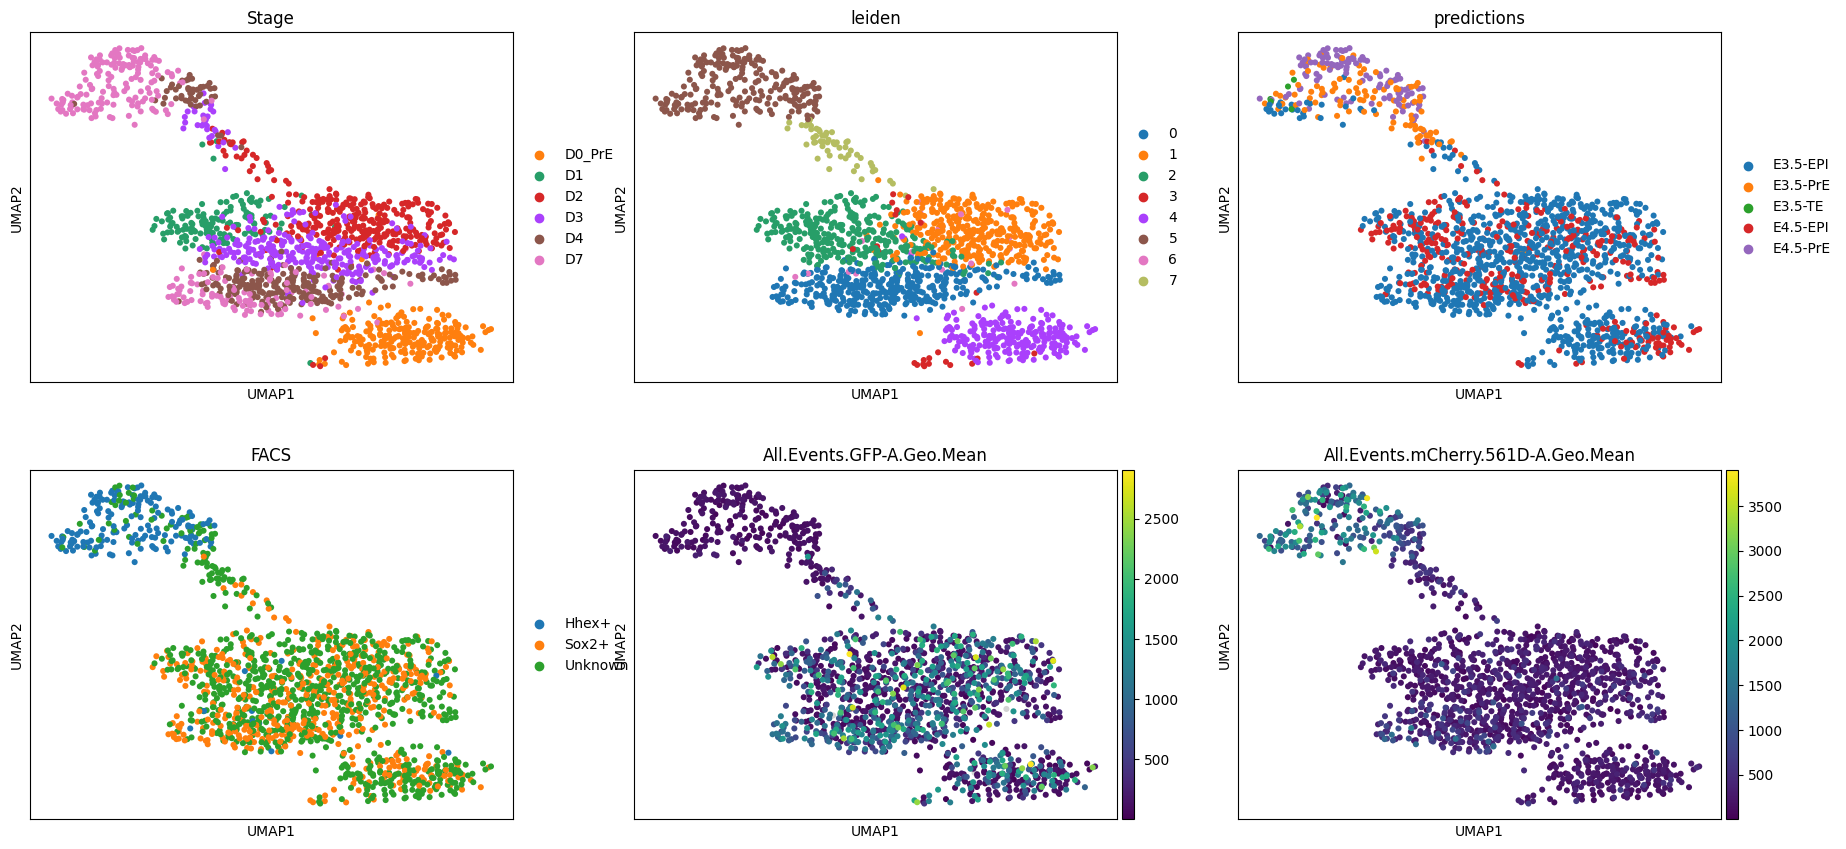

In [19]:
sc.pl.umap(vitro, color=['Stage', 'leiden', 'predictions', 'FACS', 'All.Events.GFP-A.Geo.Mean', 'All.Events.mCherry.561D-A.Geo.Mean'], ncols=3)

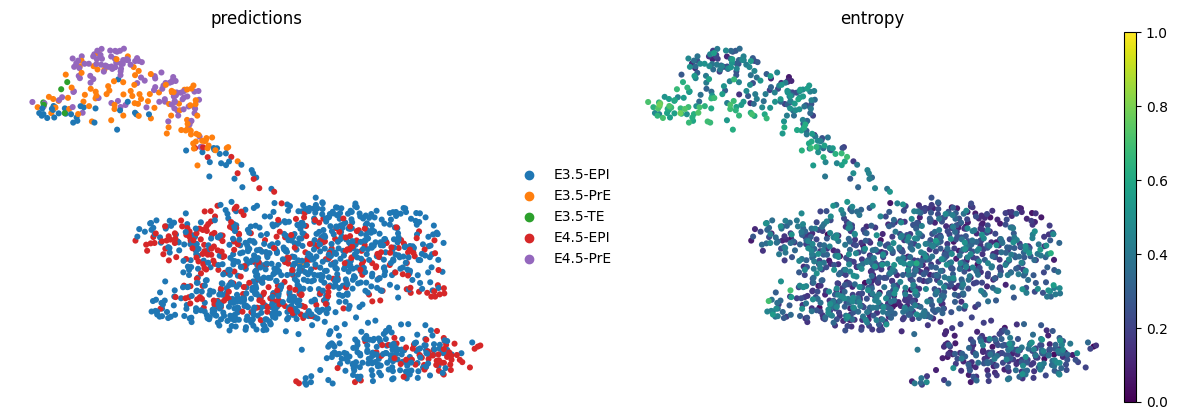

In [20]:
sc.pl.umap(vitro, color=['predictions', 'entropy'], vmax=1, vmin=0, frameon=False, save="")

<Axes: xlabel='predictions', ylabel='FACS'>

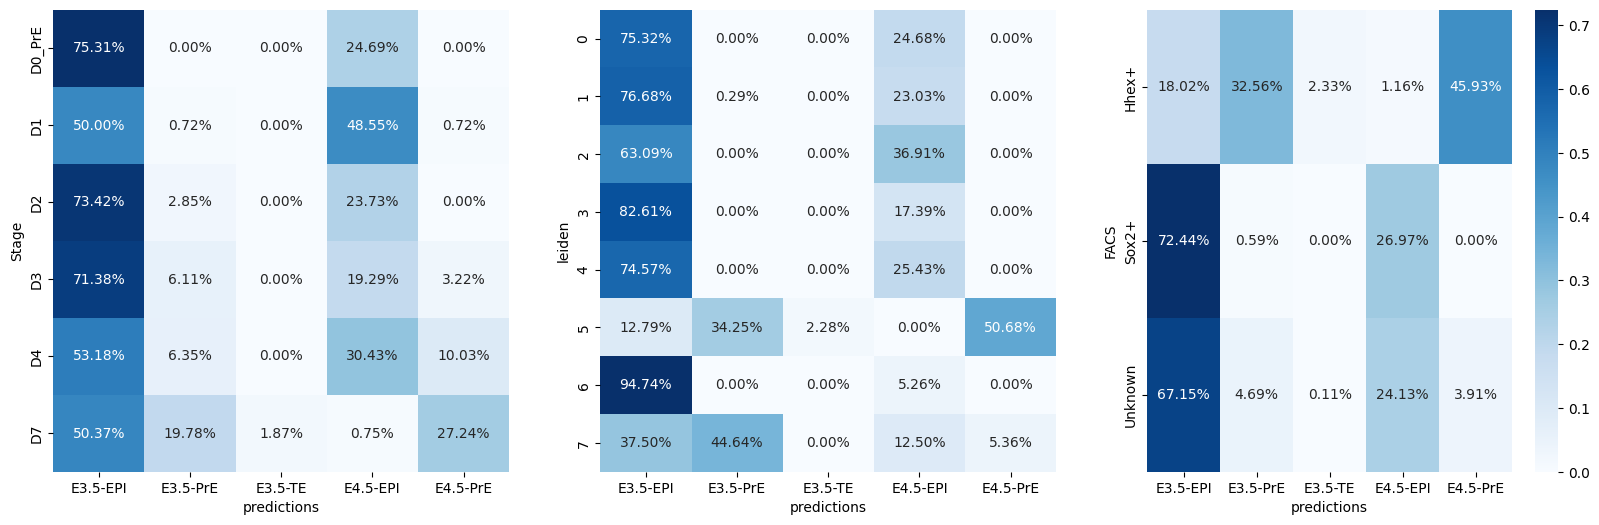

In [21]:
fig, ax = plt.subplots(1, 3, figsize=[20, 6])
sns.heatmap(sc.metrics.confusion_matrix("Stage", "predictions", vitro.obs), annot=True, fmt='.2%', cmap='Blues', ax=ax[0], cbar=False)
sns.heatmap(sc.metrics.confusion_matrix("leiden", "predictions", vitro.obs), annot=True, fmt='.2%', cmap='Blues', ax=ax[1], cbar=False)
sns.heatmap(sc.metrics.confusion_matrix("FACS", "predictions", vitro.obs), annot=True, fmt='.2%', cmap='Blues', ax=ax[2])

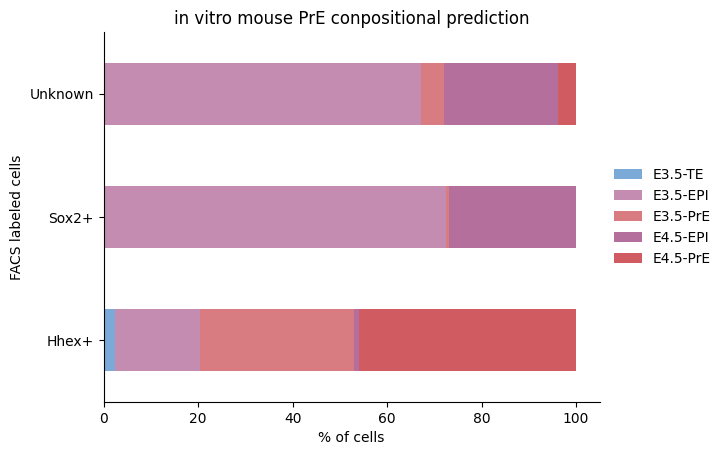

In [24]:
conf_mat = (sc.metrics.confusion_matrix('FACS', 'predictions', vitro.obs) * 100)[['E3.5-TE', 'E3.5-EPI', 'E3.5-PrE', 'E4.5-EPI', 'E4.5-PrE']]
conf_mat.plot.barh(stacked=True, color=ct_colors)
plt.legend(conf_mat.columns.str.replace('_', ' '), loc='center right', bbox_to_anchor=(1.25, 0.5), frameon=False)
plt.gca().spines[['right', 'top']].set_visible(False)
plt.xlabel('% of cells')
plt.ylabel('FACS labeled cells')
plt.title('in vitro mouse PrE conpositional prediction')

plt.savefig("../figures/mouse/00_query_facs_predictions.svg")
sc.metrics.confusion_matrix('FACS', 'predictions', vitro.obs, normalize=False).to_csv("../results/00_mouse_query.csv")

## Timepoint prediction (deprecated)

In [ ]:
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
vae = scvi.model.SCVI.load("../results/02_mouse_integration/scvi/")
vae_q = scvi.model.SCVI.load_query_data(vitro_raw, vae)

In [ ]:
X = vae_q.get_normalized_expression(return_mean=True, return_numpy=True)

In [ ]:
def tp_predict(adata: sc.AnnData, model_pkl: str, X_):
    model = pickle.load(open(model_pkl, 'rb'))
    adata.obs["tp_predictions"] = vae.adata.obs.timepoint.cat.categories[model.predict(X_)]
    
    sc.pl.umap(adata, color=['Stage', 'tp_predictions', 'leiden'], ncols=3)
    display(sc.metrics.confusion_matrix('Stage', 'tp_predictions', adata.obs) * 100)

In [ ]:
tp_predict(vitro, "../results/05_mouse_timepoint_rbf.pkl", X)

In [ ]:
tp_predict(
    vitro, 
    "../results/05_mouse_timepoint_rbf_pca15.pkl", 
    PCA(n_components=15, svd_solver='arpack').fit_transform(StandardScaler().fit(X).transform(X))
)

In [ ]:
tp_predict(
    vitro, 
    "../results/05_mouse_timepoint_poly3_pca2.pkl", 
    PCA(n_components=2, svd_solver='arpack').fit_transform(StandardScaler().fit(X).transform(X))
)

In [ ]:
tp_predict(
    vitro, 
    "../results/05_mouse_timepoint_poly3_pca30.pkl", 
    PCA(n_components=30, svd_solver='arpack').fit_transform(StandardScaler().fit(X).transform(X))
)

In [ ]:
tp_predict(vitro, "../results/05_mouse_timepoint_knn15.pkl", X)

---

In [ ]:
vitro.write("../results/06_proks_et_al.h5ad")